# Predicting Antibiotic Resistance Using Genetic Sequences
James Eapen

## Vision
I will be training a model to predict whether a genetic sequence contains a gene that confers antibiotic resistance. The dataset is a collection of artifical genetic sequences labelled with whether or not it has a resistance gene. The features are genomic sequences, made of four letter nucleotides A, C, G, and T. Groups of three nucleotides are called codons and code for a unit of a protein. The order in which they come is important as it determines the structure and function of the protein it encodes.  

The model is based on an example by Scarlat that is a binary classifier trained with convolutional and recurrent networks. Based on a review of machine learning methods on antibiotic resistance prediction, I will be adding a random forest model, a model with just a convolutional neural network and a linear regression.


## Background
Antibiotic resistance is a naturally occuring phenomenon that has
been made worse by the human abuse of antibiotics. Antibiotics are compounds that interfere with bacterial metabolism and prevent normal functioning. They cure infections by killing the bacteria or by preventing its reproduction in the host. Every antibiotic has a mode of action that depends on a it getting into and staying inside the bacterium and on structures within it that can be used to disrupt normal function. 

However, if a bacterium aquires a gene that causes a change a structure that the antibiotic distrups, the antibiotic is no longer able to work. A bacterium becomes resistant when it aquires an antibiotic resistance gene that codes for a protein that can either protect the baterium by either changing a characteristic that the antibiotic depends on to work or by pumping the antibiotic out before it can take effect.

Studies of genomes have revealed the sequences that confer resistance and there are databases of known antibiotic resistance genes. Predicting whether a bacterium is resistant to an antibiotic from these sequences can help direct patients to the right antibiotic.

The review by Su et al. examined the perfomance of a number of machine learning models on different antibiotics and bacteria. Random forests and linear regressions were common models among the studies they reviewed.

I will be using Keras for the neural networks, numpy and pandas for data manipulation and matplotlib for plotting accuracy scores. The random forest and linear regression models will be implemented with the Scikit-learn package.

## Implementation
This draft implementation is the implemtation by Scarlat on Kaggle that uses convolutional and bi-directional Gated Recurrent Unit networks. The first part uses the raw nucleotides, A, C, G, and T. The second approach takes them in groups of three calle codons that represent a unit of the protein the sequence codes. 

Since the codon approach is more successful, I will build the random forest and linear regression using the codon data to build on the Kaggle notebook.

In [0]:
# IMPORT MODULES

import os
import keras
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import time
%matplotlib inline

from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, Embedding, LSTM
from keras import regularizers, layers, preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
from sklearn.ensemble import RandomForestClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import tensorflow as tf

Using TensorFlow backend.


In [0]:
# IMPORT MODULES
# Load the dataset.npy

DataRaw = np.load('drive/My Drive/Colab Notebooks/dataset.npy', allow_pickle=True)
print(type(DataRaw))
print(DataRaw.ndim)
DataRaw

<class 'numpy.ndarray'>
0


array({'resistant': array([False, False, False, ...,  True,  True, False]), 'genes': array(['ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACCCGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       ...,
       'ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTAC

In [0]:
# As a dictionary
Datadict = DataRaw[()]
print(Datadict)

# As a dataframe
DataDf = pd.DataFrame.from_dict(Datadict)
print(DataDf.shape)
DataDf

{'resistant': array([False, False, False, ...,  True,  True, False]), 'genes': array(['ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACCCGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       ...,
       'ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA',
       'ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTC

,resistant,genes
0,False,ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACT...
1,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
2,False,ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCA...
3,False,ATGCACTACCGTATGATTCACTGGGTGATGGAAATTGACTGCAATG...
4,False,ATGCACGACCGTATCATTCACTGGATGATGGAAATTGACTGCAATG...
...,...,...
99995,False,ATGCACTACCGTATGATTCACTGGATGATGGAAACTCTCTTTGACT...
99996,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...
99997,True,ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTG...
99998,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAAT...


In [0]:
# Mean  / Max / Min column width

DataDf.fillna('').astype(str).apply(lambda x:x.str.len()).max()


resistant      5
genes        156
dtype: int64

In [0]:
# Tokenize from characters to integers (sequences and then pad / truncate data)

Datatok = DataDf.copy()
maxlen = 160 # cut off after this number of characters in a string

max_words = 4 # considers only the top number of characters in the dictionary A C T G
max_features = max_words

tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer.fit_on_texts(list(Datatok['genes']))
sequences = tokenizer.texts_to_sequences(list(Datatok['genes']))
word_index = tokenizer.word_index
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

print('Found %s unique tokens.' % len(word_index))
print('word_index', word_index)

Found 4 unique tokens.
word_index {'a': 1, 't': 2, 'c': 3, 'g': 4}


In [0]:
# Separate the label

labels = np.asarray(Datatok['resistant'])
print(Xpad.shape)
print(labels.shape)

(100000, 160)
(100000,)


In [0]:
# Check a sample
rowNum = 37149
print(Datatok['genes'][rowNum])
print(sequences[rowNum])
print(Xpad[rowNum])
print(labels[rowNum])

ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA
[1, 2, 3, 1, 3, 2, 1, 3, 3, 2, 1, 2, 1, 2, 2, 3, 1, 3, 2, 1, 2, 1, 2, 1, 1, 1, 2, 2, 1, 3, 2, 3, 1, 1, 2, 3, 2, 3, 3, 2, 1, 1, 2, 1, 1, 2, 1, 3, 2, 2, 2, 2, 3, 2, 3, 2, 3, 2, 2, 1, 1, 2, 2, 1, 3, 1, 3, 2, 2, 3, 2, 3, 1, 3, 1, 1, 1, 3, 1, 3, 2, 2, 1, 1, 3, 1, 2, 2, 1, 1, 1, 2, 3, 2, 1, 3, 3, 2, 3, 1, 3, 1, 1, 2, 1, 2, 2, 3, 2, 1, 3, 3, 1, 1, 3, 2, 2, 1]
[1 2 3 1 3 2 1 3 3 2 1 2 1 2 2 3 1 3 2 1 2 1 2 1 1 1 2 2 1 3 2 3 1 1 2 3 2
 3 3 2 1 1 2 1 1 2 1 3 2 2 2 2 3 2 3 2 3 2 2 1 1 2 2 1 3 1 3 2 2 3 2 3 1 3
 1 1 1 3 1 3 2 2 1 1 3 1 2 2 1 1 1 2 3 2 1 3 3 2 3 1 3 1 1 2 1 2 2 3 2 1 3
 3 1 1 3 2 2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
True


In [0]:
# Create train & val and test datasets with inital shuffle (as the original dataset may be arranged)

training_samples = int(Xpad.shape[0] * 0.9)
# The validation is being taken by keras - below
# test = remaining

indices = np.arange(Xpad.shape[0])
np.random.shuffle(indices) # FOR TESTING PURPOSES comment it out - to keep indices as above

Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples: ]
y_test = labels[training_samples: ]

print('ix_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

ix_train (90000, 160)
y_train (90000,)
x_test (10000, 160)
y_test (10000,)


In [0]:
# Model ... 128 CNN window 27 & Bidirectional GRU accuracy = 

model = Sequential()
model.add(Embedding(4, 1, input_length=maxlen))
model.add(layers.Conv1D(128, 27, activation='relu'))
model.add(layers.MaxPooling1D(9))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 160, 1)            4         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 134, 128)          3584      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 14, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 6, 128)            147584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 128)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)               

In [0]:
# Train / Validate model
start_time = time.time()
history = model.fit(x_train, y_train,
epochs = 10,
batch_size=32,
validation_split=0.2)
nn1_runtime = time.time() - start_time
print("Runtime: %s seconds" % nn1_runtime)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 18000 samples
Epoch 1/10
72000/72000 [==============================] - 109s 2ms/step - loss: 0.6032 - acc: 0.6401 - val_loss: 0.4937 - val_acc: 0.7162
Epoch 2/10
72000/72000 [==============================] - 115s 2ms/step - loss: 0.4762 - acc: 0.7402 - val_loss: 0.4160 - val_acc: 0.7798
Epoch 3/10
72000/72000 [==============================] - 105s 1ms/step - loss: 0.4312 - acc: 0.7634 - val_loss: 0.3925 - val_acc: 0.7861
Epoch 4/10
72000/72000 [==============================] - 105s 1ms/step - loss: 0.4134 - acc: 0.7737 - val_loss: 0.3822 - val_acc: 0.7848
Epoch 5/10
72000/72000 [==============================] - 101s 1ms/step - loss: 0.4036 - acc: 0.7768 - val_loss: 0.3830 - val_acc: 0.7937
Epoch 6/10
72000/72000 [==============================] - 96s 1ms/step - loss: 0.3960 - acc: 0.7818 - val_loss: 0.3826 - val_acc: 0.7977
Epoch 7/10
72000/72000 [==============================] - 98s 1ms/step - loss: 0.3919 - acc: 0.7816 - val_loss: 0.3701 - va

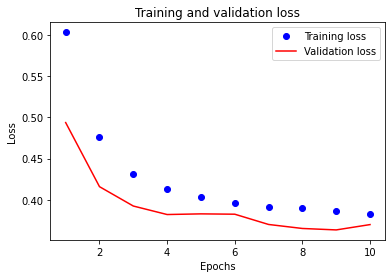

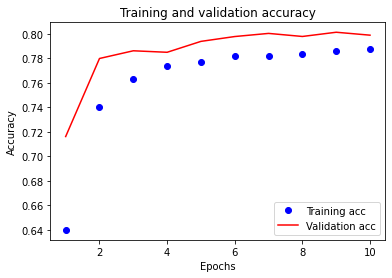

In [0]:
# Learning curves

# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
# Final Predict on test

final_predictions = model.predict(x_test)
print(final_predictions)

# Modify the raw final_predictions - prediction probs  - into 0 and 1
# Cutoff point = 0.5

Preds = final_predictions.copy()
print(len(Preds))

Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
print(Preds)

[[5.3787279e-01]
 [9.9958265e-01]
 [4.7286084e-01]
 ...
 [4.8704684e-01]
 [8.3965063e-04]
 [4.9496046e-01]]
10000
[[1.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


A confusion matrix can be used to visualize the results and see how well the model is making its predictions. It shows the true and false positives and negatives. This is useful because a false negative prediction can be clinically more damaging than a false postive prediction since it is worse to take ineffective action against an antibiotic resistant bacterium than to take an intensive treatment against a susceptible baterium. 

In [0]:
# Confusion matrix

conf_mx = confusion_matrix(y_test, Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  4046
FP:  936
FN:  1131
TP:  3887
0.7746113989637305 0.8059299191374663


In [0]:
# Function to visualize the confusion matrix

def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,
                          normalize=False):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

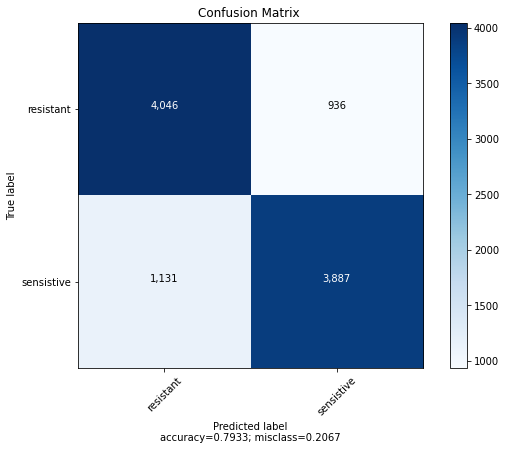

In [0]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['resistant', 'sensistive'],
                      title        = "Confusion Matrix ")

In [0]:
print ('precision ',precision_score(y_test, Preds))
print ('recall ',recall_score(y_test, Preds) )
print ('accuracy ',accuracy_score(y_test, Preds))
print ('F1 score ',f1_score(y_test, Preds))

precision  0.8059299191374663
recall  0.7746113989637305
accuracy  0.7933
F1 score  0.7899603698811096


AUC: 0.793


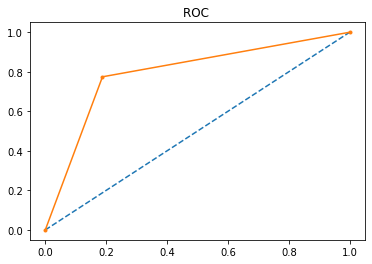

In [0]:
# AUC/ROC curves should be used when there are roughly equal numbers of observations for each class
# Precision-Recall curves should be used when there is a moderate to large class imbalance

# calculate AUC
auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

f1=0.790 ap=0.737


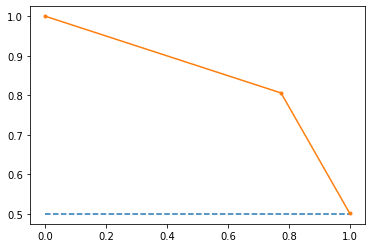

In [0]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = f1_score(y_test, Preds)
# calculate average precision score
ap = average_precision_score(y_test, Preds)
print('f1=%.3f ap=%.3f' % (f1, ap))
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.show()

### Codon Tokenization

In [0]:
# From nucleotides to codons ... w/o considering the start / stop codons as the data is synthetic and may not have these

DataCod = DataDf.copy()

Codons = list(DataCod['genes'])
print(len(Codons))

for n in range(len(Codons)):
    Codons[n] = list([Codons[n][i:i+3] for i in range(0, len(Codons[n]), 3)])
    
DataCod['codons'] = Codons
DataCod

100000


,resistant,genes,codons
0,False,ATGCACTACCGTATGATCCCCCTTCACTGGATGATGGAAATTGACT...,"[ATG, CAC, TAC, CGT, ATG, ATC, CCC, CTT, CAC, ..."
1,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
2,False,ATGCACTACCGTATGATTCACTGGATCGTGATGGAAATTGACTGCA...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATC, ..."
3,False,ATGCACTACCGTATGATTCACTGGGTGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, GTG, ..."
4,False,ATGCACGACCGTATCATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, GAC, CGT, ATC, ATT, CAC, TGG, ATG, ..."
...,...,...,...
99995,False,ATGCACTACCGTATGATTCACTGGATGATGGAAACTCTCTTTGACT...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
99996,False,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
99997,True,ATGCACTACCGTATGATTCACTGGATGATGGAAACTGCAATGGCTG...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."
99998,True,ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTTGCAAT...,"[ATG, CAC, TAC, CGT, ATG, ATT, CAC, TGG, ATG, ..."


In [0]:
# Tokenize from codons to integers (sequences and then pad / truncate data)

maxlen = 53 # cut off after this number of codons in a list

max_words = 64 # considers only the top number of codons  in the dictionary (It finds 66 below because of 'a' and 'ga')
max_features = max_words

#tokenizer = Tokenizer(num_words=max_words, char_level=True)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(DataCod['codons']))
sequences = tokenizer.texts_to_sequences(list(DataCod['codons']))
word_index = tokenizer.word_index
Xpad = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post', value=0)

print('Found %s unique tokens.' % len(word_index))
print('word_index', word_index)

Found 66 unique tokens.
word_index {'cac': 1, 'cgt': 2, 'aat': 3, 'atg': 4, 'tac': 5, 'att': 6, 'tgg': 7, 'gac': 8, 'tgc': 9, 'act': 10, 'gtt': 11, 'gaa': 12, 'aaa': 13, 'cag': 14, 'tga': 15, 'ttg': 16, 'gct': 17, 'ttc': 18, 'tct': 19, 'ggc': 20, 'aca': 21, 'taa': 22, 'ctg': 23, 'ata': 24, 'caa': 25, 'ctt': 26, 'tcg': 27, 'gtc': 28, 'aac': 29, 'gga': 30, 'acg': 31, 'gca': 32, 'tta': 33, 'cta': 34, 'acc': 35, 'gat': 36, 'tca': 37, 'tat': 38, 'agg': 39, 'tgt': 40, 'gtg': 41, 'cga': 42, 'cgc': 43, 'ttt': 44, 'aga': 45, 'ggt': 46, 'ctc': 47, 'cca': 48, 'ccg': 49, 'gcg': 50, 'a': 51, 'ga': 52, 'tag': 53, 'atc': 54, 'cat': 55, 'agt': 56, 'cgg': 57, 'aag': 58, 'gag': 59, 'cct': 60, 'gta': 61, 'ggg': 62, 'tcc': 63, 'agc': 64, 'ccc': 65, 'gcc': 66}


In [0]:
# Separate the label

labels = np.asarray(DataCod['resistant'])
print(Xpad.shape)
print(labels.shape)

(100000, 53)
(100000,)


In [0]:
# Check a sample

rowNum = 37149
print(DataCod['genes'][rowNum])
print(DataCod['codons'][rowNum])
print(sequences[rowNum])
print(Xpad[rowNum])
print(labels[rowNum])

ATGCACTACCGTATGATTCACTGGATGATGGAAATTGACTGCAATGGCTGCGCTAATAATACTTTGTCTCGTCGTTGGAATTACGACTTCTGGCACAAACACGTTGAACAGGTTAAATGCTACCGTCACAATATTCGTGACCAGACTTGA
['ATG', 'CAC', 'TAC', 'CGT', 'ATG', 'ATT', 'CAC', 'TGG', 'ATG', 'ATG', 'GAA', 'ATT', 'GAC', 'TGC', 'AAT', 'GGC', 'TGC', 'GCT', 'AAT', 'AAT', 'ACT', 'TTG', 'TCT', 'CGT', 'CGT', 'TGG', 'AAT', 'TAC', 'GAC', 'TTC', 'TGG', 'CAC', 'AAA', 'CAC', 'GTT', 'GAA', 'CAG', 'GTT', 'AAA', 'TGC', 'TAC', 'CGT', 'CAC', 'AAT', 'ATT', 'CGT', 'GAC', 'CAG', 'ACT', 'TGA']
[4, 1, 5, 2, 4, 6, 1, 7, 4, 4, 12, 6, 8, 9, 3, 20, 9, 17, 3, 3, 10, 16, 19, 2, 2, 7, 3, 5, 8, 18, 7, 1, 13, 1, 11, 12, 14, 11, 13, 9, 5, 2, 1, 3, 6, 2, 8, 14, 10, 15]
[ 4  1  5  2  4  6  1  7  4  4 12  6  8  9  3 20  9 17  3  3 10 16 19  2
  2  7  3  5  8 18  7  1 13  1 11 12 14 11 13  9  5  2  1  3  6  2  8 14
 10 15  0  0  0]
True


In [0]:
# Create train & val and test datasets with inital shuffle (as the original dataset may be arranged)

training_samples = int(Xpad.shape[0] * 0.9)
# The validation is being taken by keras - below
# test = remaining

indices = np.arange(Xpad.shape[0])
np.random.shuffle(indices) # FOR TESTING PURPOSES comment it out - to keep indices as above

Xpad = Xpad[indices]
labels = labels[indices]

x_train = Xpad[:training_samples]
y_train = labels[:training_samples]
x_test = Xpad[training_samples: ]
y_test = labels[training_samples: ]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (90000, 53)
y_train (90000,)
x_test (10000, 53)
y_test (10000,)


In [0]:
# Model ... 64 CNN window 27 & Bidirectional GRU accuracy = 0.99

model = Sequential()
model.add(Embedding(64, 1, input_length=maxlen))
model.add(layers.Conv1D(128, 27, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, 9, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Bidirectional(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 53, 1)             64        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 27, 128)           3584      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 9, 128)            0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 128)            147584    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)               

In [0]:
# Train / Validate model
start_time = time.time()
history = model.fit(x_train, y_train,
epochs = 10,
batch_size=32,
validation_split=0.2)
nn2_runtime = time.time() - start_time
print("Runtime: %s seconds" % nn2_runtime)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 72000 samples, validate on 18000 samples
Epoch 1/10
72000/72000 [==============================] - 55s 758us/step - loss: 0.0887 - acc: 0.9694 - val_loss: 0.0481 - val_acc: 0.9844
Epoch 2/10
72000/72000 [==============================] - 51s 709us/step - loss: 0.0491 - acc: 0.9847 - val_loss: 0.0486 - val_acc: 0.9845
Epoch 3/10
72000/72000 [==============================] - 52s 722us/step - loss: 0.0478 - acc: 0.9847 - val_loss: 0.0477 - val_acc: 0.9845
Epoch 4/10
72000/72000 [==============================] - 52s 729us/step - loss: 0.0456 - acc: 0.9849 - val_loss: 0.0452 - val_acc: 0.9844
Epoch 5/10
72000/72000 [==============================] - 53s 731us/step - loss: 0.0454 - acc: 0.9848 - val_loss: 0.0432 - val_acc: 0.9845
Epoch 6/10
72000/72000 [==============================] - 57s 788us/step - loss: 0.0444 - acc: 0.9849 - val_loss: 0.0444 - val_acc: 0.9844
Epoch 7/10
72000/72000 [==============================] - 54s 747us/step - loss: 0.0441 - acc: 0.9849 - val_loss: 0.

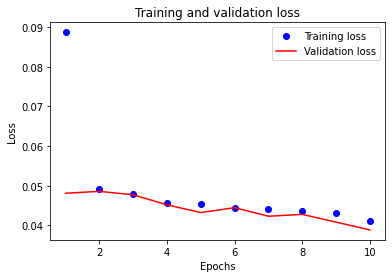

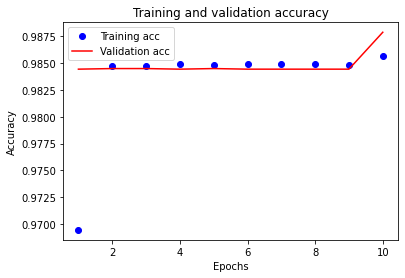

In [0]:
# Learning curves

# VALIDATION LOSS curves

plt.clf()
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, (len(history_dict['loss']) + 1))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# VALIDATION ACCURACY curves

plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, (len(history_dict['acc']) + 1))
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [0]:
# Final Predict on test

final_predictions = model.predict(x_test)
print(final_predictions)

# Modify the raw final_predictions - prediction probs  - into 0 and 1
# Cutoff point = 0.5

Preds = final_predictions.copy()
print(len(Preds))

Preds[ np.where( Preds >= 0.5 ) ] = 1
Preds[ np.where( Preds < 0.5 ) ] = 0
print(Preds)

[[5.9496604e-05]
 [9.9987805e-01]
 [7.5064359e-05]
 ...
 [5.9463986e-05]
 [5.9465234e-05]
 [5.9861708e-05]]
10000
[[0.]
 [1.]
 [0.]
 ...
 [0.]
 [0.]
 [0.]]


In [0]:
# Confusion matrix

conf_mx = confusion_matrix(y_test, Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  5167
FP:  2
FN:  96
TP:  4735
0.9801283378182571 0.9995777918513827


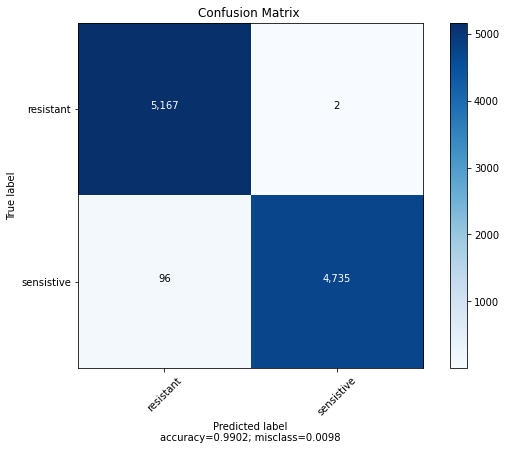

In [0]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['resistant', 'sensistive'],
                      title        = "Confusion Matrix ")

AUC: 0.990


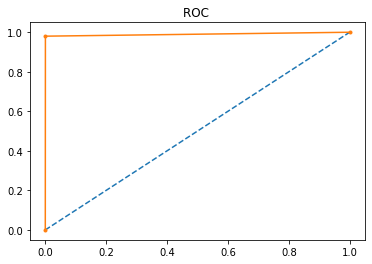

In [0]:
# AUC/ROC curves should be used when there are roughly equal numbers of observations for each class
# Precision-Recall curves should be used when there is a moderate to large class imbalance

# calculate AUC
auc = roc_auc_score(y_test, Preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

f1=0.990 ap=0.989


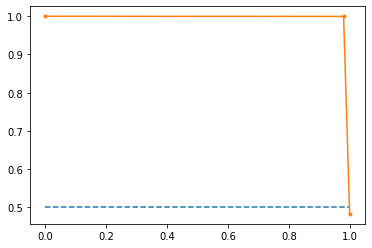

In [0]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, Preds)
# calculate F1 score
f1 = f1_score(y_test, Preds)
# calculate average precision score
ap = average_precision_score(y_test, Preds)
print('f1=%.3f ap=%.3f' % (f1, ap))
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.show()

## Random Forest Classifier

This random forest classifier creates 100 decision trees during the training phase. The final model is the most commmon of the classes


In [0]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy', verbose=1)
rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 1,
 'warm_start': False}

In [0]:
start_time = time.time()
rf = rf.fit(x_train, y_train)
rf_runtime = time.time() - start_time
print("Runtime: %s seconds" % rf_runtime)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Runtime: 8.223840475082397 seconds


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    8.2s finished


In [0]:
rf_Preds = rf.predict(x_test)
print("Test accuracy score: ", accuracy_score(y_test, rf_Preds))


Test accuracy score:  0.9893


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [0]:
# Confusion matrix

conf_mx = confusion_matrix(y_test, rf_Preds)

TN = conf_mx[0,0]
FP = conf_mx[0,1]
FN = conf_mx[1,0]
TP = conf_mx[1,1]

print ('TN: ', TN)
print ('FP: ', FP)
print ('FN: ', FN)
print ('TP: ', TP)

recall = TP/(TP+FN)
precision = TP/(TP+FP)

print (recall, precision)

TN:  5037
FP:  2
FN:  105
TP:  4856
0.9788349123160653 0.9995883079456567


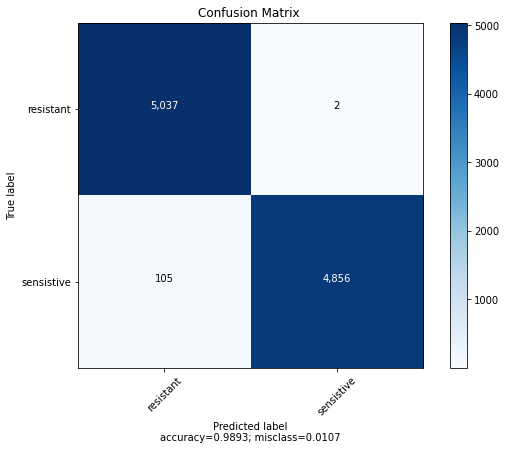

In [0]:
plot_confusion_matrix(conf_mx, 
                      normalize    = False,
                      target_names = ['resistant', 'sensistive'],
                      title        = "Confusion Matrix ")

AUC: 0.990


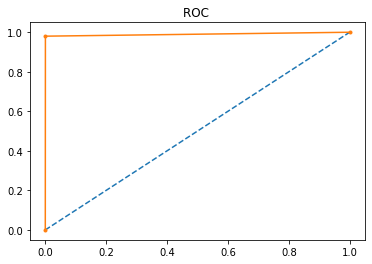

In [0]:
# AUC/ROC curves should be used when there are roughly equal numbers of observations for each class
# Precision-Recall curves should be used when there is a moderate to large class imbalance

# calculate AUC
auc = roc_auc_score(y_test, rf_Preds)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, rf_Preds)
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
plt.title('ROC ')
plt.show()

f1=0.990 ap=0.989


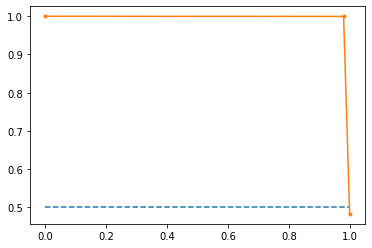

In [0]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, rf_Preds)
# calculate F1 score
f1 = f1_score(y_test, rf_Preds)
# calculate average precision score
ap = average_precision_score(y_test, rf_Preds)
print('f1=%.3f ap=%.3f' % (f1, ap))
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
plt.plot(recall, precision, marker='.')
plt.show()

In [0]:
from sklearn.linear_model import LogisticRegression 
reg = LogisticRegression(max_iter=1000).fit(x_train, y_train)
reg.score(x_train, y_train)
accuracy_score(y_test, reg.predict(x_test))


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.9158

## Results

The codon based model had much better success than the raw nucleotide based model and had no false positives. 

Random forest: 

Linear regression: 

## Implications

The ability to predict antibiotic resistance from genomic data will be an asset to fighting infections and antibiotic resistant bacteria. 

This dataset was a synthetic one and may have been easy to work with compared to a full bacterial genome. A full genome will be harder to analyze and predict resistance with and the chances of false negatives will be higher as new mutations arise that confer bacteria with novel resistance mechanisms. 

## Citations
Scarlat, Alexander, Predict antibiotic resistance w gene sequence, Kaggle. https://www.kaggle.com/drscarlat/predict-antibiotic-resistance-w-gene-sequence/data

Su, M., Satola, S. W., & Read, T. D. (2019). Genome-Based Prediction of Bacterial Antibiotic Resistance. Journal of clinical microbiology, 57(3), e01405-18. https://doi.org/10.1128/JCM.01405-18